# Project IV: [OII] fluxes <a class="tocSkip">
    
the aim of this notebook is to combine the HII-region and cluster catalogues. 
    
In this notebook we do the matching on a per galaxie basis. For each resolution, a set of output files is produced that matches the nebulae to the association catalogue


In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from astrotools.packages import *

from astrotools.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
logging.basicConfig(stream=sys.stdout,datefmt='%H:%M:%S',level=logging.INFO)
logger = logging.getLogger(__name__)

basedir = Path('..')  # where we save stuff (and )
data_ext = Path('a:')/'Archive' # raw data

# we use the sample table for basic galaxy properties
sample_table = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample_table.add_index('name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])

## Read in data

the galaxies listed in `hst_sample` have a cluster catalogue. The galaxies listed in `muse_sample` have astrosat observations to measure the FUV.

In [24]:
# choose which version of the association catalogue to use
version = 'v1p2'
HSTband = 'nuv'
scalepc = 32

name = 'NGC2835'

### MUSE (DAP + nebulae catalogues)

In [26]:
from pnlf.auxiliary import filter_table
from pnlf.io import ReadLineMaps

p = {x:sample_table.loc[name][x] for x in sample_table.columns}

# DAP linemaps (Halpha and OIII)
filename = next((data_ext/'MUSE'/'DR2.1'/'copt'/'MUSEDAP').glob(f'{name}*.fits'))
copt_res = float(filename.stem.split('-')[1].split('asec')[0])
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))
    OIII = NDData(data=hdul['OIII5006_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['OIII5006_FLUX_ERR'].data),
                    mask=np.isnan(hdul['OIII5006_FLUX'].data),
                    meta=hdul['OIII5006_FLUX'].header,
                    wcs=WCS(hdul['OIII5006_FLUX'].header)) 

# the original catalogue from Francesco
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue_v2p1.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])


nebulae['HIIregion'] = (nebulae['BPT_NII']==0) & (nebulae['BPT_SII']==0) & (nebulae['BPT_OI']==0)
HII_regions = filter_table(nebulae,gal_name=name,BPT_NII=0,BPT_SII=0,BPT_OI=0)
nebulae = filter_table(nebulae,gal_name=name)
nebulae.add_index('region_ID')
HII_regions.add_index('region_ID')

filename = data_ext/'Products'/'Nebulae_catalogs'/'Nebulae_catalogue_v2'/'spatial_masks'/f'{name}_nebulae_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan
    
print(f'{name}: {len(HII_regions)} HII-regions in final catalogue')

NGC2835: 847 HII-regions in final catalogue


### HST

**white light + filter images**

In [2]:
from cluster.io import read_associations

target  = name.lower()

# whitelight image (we set 0s to nan)
white_light_filename = data_ext / 'HST' / 'white_light' / f'{name.lower()}_white_24rgb.fits'
if white_light_filename.is_file():
    with fits.open(white_light_filename) as hdul:
        hst_whitelight = NDData(hdul[0].data,mask=hdul[0].data==0,meta=hdul[0].header,wcs=WCS(hdul[0].header))
        hst_whitelight.data[hst_whitelight.data==0] = np.nan
else:
    logging.warning('no white light image')
    
# filter image with uncertainties
filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{name.lower()}_f275w_v1_exp-drc-sci.fits'
with fits.open(filename) as hdul:
    F275 = NDData(hdul[0].data,
                  mask=hdul[0].data==0,
                  meta=hdul[0].header,
                  wcs=WCS(hdul[0].header))
filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{name.lower()}_f275w_v1_err-drc-wht.fits'
with fits.open(filename) as hdul:
    F275.uncertainty = StdDevUncertainty(hdul[0].data)
    
associations, associations_mask = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,
                                                    HSTband=HSTband,scalepc=scalepc,version=version)


print(f'{name}: {len(associations)} associations in catalogue')    
# associations mask

SyntaxError: invalid syntax (<ipython-input-2-4d0dc4c17217>, line 3)

### SITELLE [OII]

In [27]:
with fits.open(basedir/'..'/'sitelle'/'data_v2p1'/'maps'/'NGC2835_OII_map_reprojected.fits') as hdul:
    OII = NDData(data=hdul[1].data,
                 meta=hdul[1].header,
                 wcs=WCS(hdul[1].header))

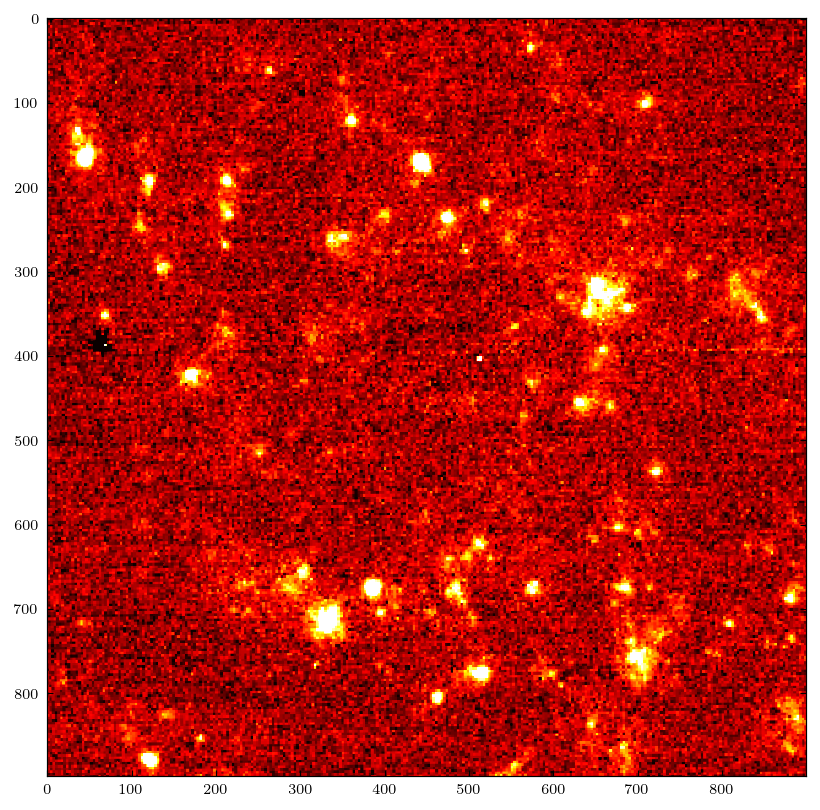

In [46]:
from astrotools.plot import quick_plot

quick_plot(OII.data)

In [43]:
with fits.open(basedir/'data'/'external'/'N2835_TG10_sig3.50000_hiiphot.fits') as hdul:
    typhoon_mask = NDData(data=hdul[0].data,
                 meta=hdul[0].header,
                 wcs=WCS(hdul[0].header))
    
names = ['HIIregion','Rgal(kpc)','Halpha','Halpha_e','Hbeta','Hbeta_e',
         'OIII5007','OIII5007_e','OIII4636','OIII4636_e',
         'NII6583','NII6583_e','SII6716,31','SII6716,31_e',
         'OII3726,29','OII3726,29_e','SII6716','SII6716_e',
         'SII6731','SII6731_e']

typhoon_catalogue = ascii.read(basedir/'data'/'external'/'NGC2835_HIIdata_notdereddened.dat',names=names)

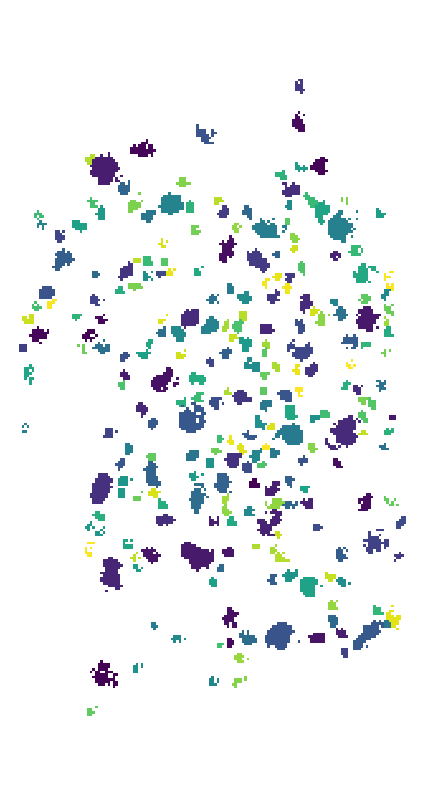

In [56]:
ax = quick_plot(typhoon_mask.data,cmap=plt.cm.viridis,alpha=0.7)
ax.set_ylim([200,500])
ax.axis('off')
plt.show()

In [32]:
from reproject import reproject_interp
typhoon_muse, _  = reproject_interp(typhoon_mask,
                                   output_projection=nebulae_mask.wcs,
                                   shape_out=nebulae_mask.data.shape,
                                   order='nearest-neighbor')    

ValueError: Output WCS has celestial components but input WCS does not